In [1]:
Update = False

# Simple Bitcoin predictive Model

## Imports & API

### Imports

In [2]:
import json
import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("darkgrid")

#scrap / API
#import praw
import requests 

#Testing Stationarity
from statsmodels import tsa

#LSTM RNN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
with open('keys.json') as f:
    key = json.loads(f.read())

### BitCoin Market API Fetching & Cleaning

Variables of note: <br>
```c_code``` = Crypto value's code <br>
```c_market``` = Crypto value's market <br>
```c_``` = Cryto value's common name <br>
```crypto.columns = ['open','high','low','close','volume','cap']```

In [4]:
#declaring Fetch parameters
c_code = 'BTC'
c_market = 'USD'

if Update:
    #Fetching Data
    cryptos = requests.get("https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={}&market={}&apikey={}".format(c_code,c_market,key['bit_api_key']))

    #Assigning "name" for ease
    c_ = cryptos.json()['Meta Data']['3. Digital Currency Name']

    #Organizing Data
    crypto = pd.DataFrame.from_dict(cryptos.json()['Time Series (Digital Currency Daily)'],orient='index',dtype='float')
    crypto = crypto.drop(['1b. open (USD)','2b. high (USD)','3b. low (USD)','4b. close (USD)'],axis=1)
    crypto.columns = ['open','high','low','close','volume','cap']
    crypto.index = pd.to_datetime(crypto.index)

    #Cleaning Missing Data
    print("There are {} days between the first and last time stamp, the API captured {} days.".format(str(crypto.index[-1] - crypto.index[0]).split(" ")[0],len(crypto)))

    if int(str(crypto.index[-1] - crypto.index[0]).split(" ")[0]) - len(crypto) > 5:
        idx = pd.date_range(crypto.index[0], crypto.index[-1])
        crypto = crypto.reindex(idx, fill_value=np.nan)
        print("So we will need to interpolate the {} missing days.".format(crypto.isnull().sum()[0]))
        crypto = crypto.interpolate()
    else:
        print("as such we dont need to interpolate any missing days")

    crypto.to_csv('./Data/Market.csv')

else:
    #will import last fetched csv
    c_ = c_code
    crypto = pd.read_csv('./Data/Market.csv',index_col=0)
    crypto.index = pd.to_datetime(crypto.index)

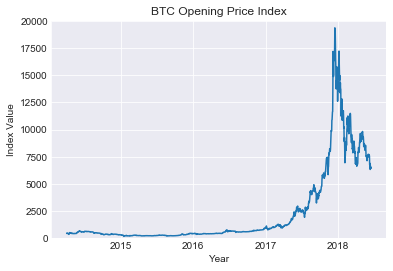

In [5]:
#Sanity Check
crypto.open.plot()
plt.title('{} Opening Price Index'.format(c_))
plt.ylabel('Index Value')
plt.ylim(0,20000)
plt.xlabel('Year');

### Reddit API Fetching & Cleaning - WARNING: Reddit updated their API, using old csv

In [6]:
# reddit = praw.Reddit(client_id=key["Reddit"]['client_id'],
#                      client_secret=key["Reddit"]['client_secret'],
#                      password=key["Reddit"]['password'],
#                      user_agent=key["Reddit"]['user_agent'],
#                      username=key["Reddit"]['username'])

In [7]:
def scrap_time(sub,start=1514764800,end=round(time.time())):
    """
    pulls all subreddit threads from January 1st 2018 (1514764800) 
    until time.now, unless specified
    collects post:
    Title, Score, # of Comments, Post Date, Is_video(boolean)
    """
    funny = reddit.subreddit(sub)
    hot_funny = funny.submissions(start,end)

    funny_list = []
    for submit in tqdm(hot_funny):
        if not submit.stickied:
            fun = {}
            fun['title'] = submit.title
            fun['score'] = submit.score
            fun['comments'] = submit.num_comments
            fun['date'] = datetime.datetime.fromtimestamp(submit.created)
            fun['is_video'] = submit.is_video
            funny_list.append(fun)
    df = pd.DataFrame(funny_list)
    return(df)

In [8]:
#reddit = scrap_time('CryptoCurrency',1521889600)

In [9]:
# #HOT LIMIT 100
# funny_list = []
# for submit in reddit.subreddit('CryptoCurrency').hot(limit=100):
#     fun = {}
#     fun['title'] = submit.title
#     fun['score'] = submit.score
#     fun['comments'] = submit.num_comments
#     fun['date'] = datetime.datetime.fromtimestamp(submit.created)
#     fun['is_video'] = submit.is_video
#     funny_list.append(fun)
# df = pd.DataFrame(funny_list)

In [69]:
reddit = pd.read_csv('./Data/Reddit_Crypto-Copy1.csv')

reddit.title = reddit.title.str.lower()
reddit = reddit.drop('Unnamed: 0',axis=1)
reddit.date = pd.to_datetime(reddit['date']).dt.date

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

reddit_sent = pd.DataFrame(columns=['compound','neg','neu','pos'],index=None)
results = []
for sentence in tqdm(reddit.title):
    ss = sia.polarity_scores(sentence)
    results.append(ss)
reddit_sent = reddit_sent.append(results)

reddit = reddit.merge(reddit_sent,left_index=True,right_index=True)

reddit['neg_s'] = reddit['neg']*reddit['score']
reddit['pos_s'] = reddit['pos']*reddit['score']
reddit['neu_s'] = reddit['neu']*reddit['score']
#tqdm

100%|██████████| 82170/82170 [00:34<00:00, 2407.02it/s]


In [70]:
eda = pd.DataFrame(reddit.groupby('date')['pos_s','neg_s'].sum())

In [74]:
eda['Bitcoint'] = crypto.close
eda.index = pd.to_datetime(eda.index)

/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  if __name__ == '__main__':


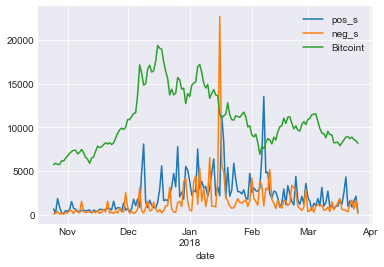

In [76]:
eda.resample('d').plot()

In [ ]:
#I am only doing the number of comments per day in the cryt subreddit

reddit = pd.DataFrame(reddit.groupby('date')['comments','score'].sum())
#reddit = pd.DataFrame(reddit.groupby('date')['neg_s','pos_s'].sum())
reddit.index = pd.to_datetime(reddit.index)

In [14]:
#Cleaning Missing Data
print("There are {} days between the first and last time stamp, however our API captured {} days.".format(str(reddit.index[-1] - reddit.index[0]).split(" ")[0],len(reddit)))

if int(str(reddit.index[-1] - reddit.index[0]).split(" ")[0]) - len(reddit) > 5:
    idx = pd.date_range(reddit.index[0], reddit.index[-1])
    reddit = reddit.reindex(idx, fill_value=np.nan)
    print("So we will need to interpolate the {} missing days.".format(reddit.isnull().sum()[0]))
    reddit = reddit.interpolate()
else:
    print("as such we dont need to interpolate any missing days")

There are 152 days between the first and last time stamp, however our API captured 153 days.
as such we dont need to interpolate any missing days


In [15]:
#I will eventually implment a predictor comparing reddit comments with the values
#bit = bit.join(reddit)

In [16]:
crypto = crypto.merge(reddit,left_index=True, right_index=True,how='left')

## Preliminary EDA

First off let us resample the entire Bitcoin opening value Dataset by: 

```
Daily means
Weekly means
Monthly means
Yearly means```

In [17]:
df_daily = crypto.resample('D').mean()

# Resampling to weekly frequency
df_week = crypto.resample('W').mean()

# Resampling to monthly frequency
df_month = crypto.resample('M').mean()

# Resampling to annual frequency
df_year = crypto.resample('A-DEC').mean()

# Resampling to quarterly frequency
#df_Q = crypto.resample('Q-DEC').mean()

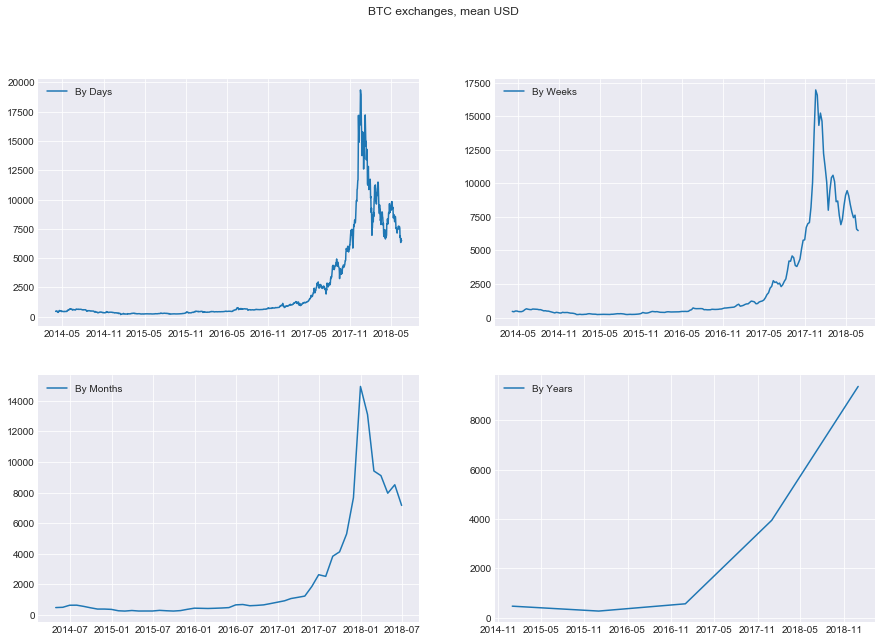

In [18]:
fig = plt.figure(figsize=[15, 10])
plt.suptitle('{} exchanges, mean {}'.format(c_,c_market))

plt.subplot(221)
plt.plot(df_daily.open, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_week.open, '-', label='By Weeks')
plt.legend()

plt.subplot(223)
plt.plot(df_month.open, '-', label='By Months')
plt.legend()

plt.subplot(224)
plt.plot(df_year.open, '-', label='By Years')
plt.legend()

plt.show()

## More_Rel

The lagging tail from 2014-2016 will likely be a problem.

As to avoid having more weight given to the time during which Bitcoin was worthless.
- ```more_rel``` will be a timeseries after Oct.25.2017, once Bitcoin has become 'more relivant'


- The reasoning being:

"Bitcoin's very low value could be highly due to its nature being unknown to the majority of the public, after that arbitrary point, it became more well known and thus more active"

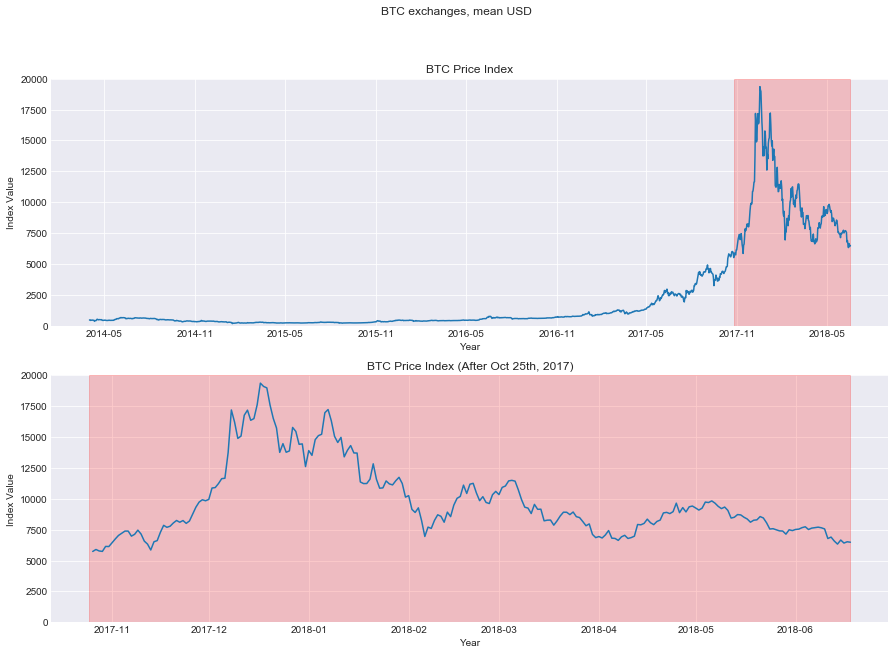

In [19]:
fig = plt.figure(figsize=[15, 10])
plt.suptitle('{} exchanges, mean {}'.format(c_,c_market))


plt.subplot(211)
plt.plot(crypto['open'], '-', label='By Days')
plt.axvspan('2017-10-25', crypto.index[-1], color='red', alpha=0.2)

plt.title('{} Price Index'.format(c_))
plt.ylabel('Index Value')
plt.ylim(0,20000)
plt.xlabel('Year')

plt.subplot(212)
plt.plot(crypto[crypto.index>'2017-10-25']['open'], '-', label='By Days')
plt.axvspan('2017-10-25', crypto.index[-1], color='red', alpha=0.2)

plt.title('{} Price Index (After Oct 25th, 2017)'.format(c_))
plt.ylabel('Index Value')
plt.ylim(0,20000)
plt.xlabel('Year');

plt.show()

In [20]:
crypto.columns

Index(['open', 'high', 'low', 'close', 'volume', 'cap', 'comments', 'score'], dtype='object')

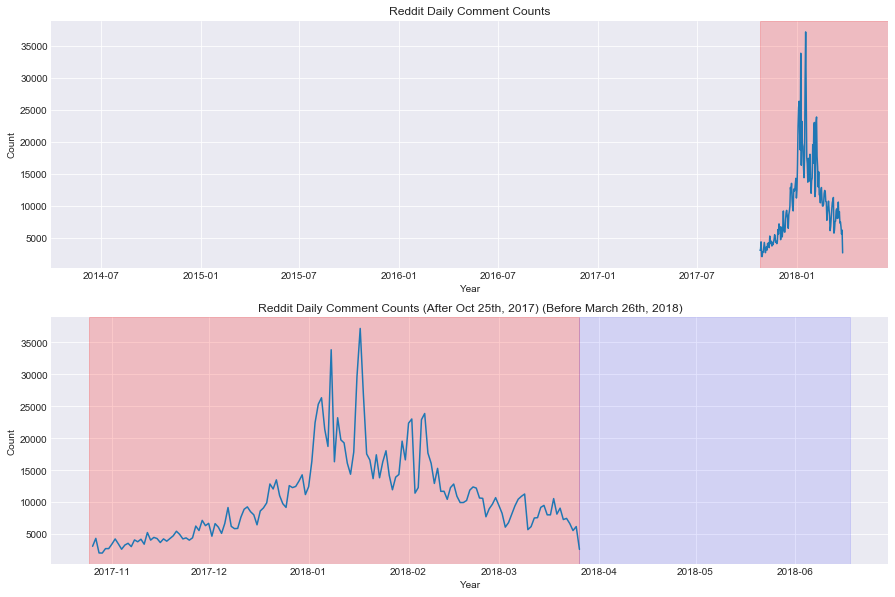

In [21]:
fig = plt.figure(figsize=[15, 10])

plt.subplot(211)
plt.plot(crypto['comments'], '-', label='By Days')
plt.axvspan('2017-10-25', crypto.index[-1], color='red', alpha=0.2)
plt.xlim(crypto.index[0],crypto.index[-1])
plt.title('Reddit Daily Comment Counts'.format(c_))
plt.ylabel('Count')
plt.xlabel('Year')

plt.subplot(212)
plt.plot(crypto[crypto.index>'2017-10-25']['comments'], '-', label='By Days')
plt.axvspan('2017-10-25', reddit.index[-1], color='red', alpha=0.2)

plt.axvspan(reddit.index[-1], crypto.index[-1], color='blue', alpha=0.1)


plt.title('Reddit Daily Comment Counts (After Oct 25th, 2017) (Before March 26th, 2018)'.format(c_))
plt.ylabel('Count')
plt.xlabel('Year');

plt.show()

In [22]:
crypto = crypto.dropna()

#### Our target is to predict the value of bitcoin a week from the end of a training set

As to avoid having more weight given to the time during which Bitcoin was worthless.
- I am using the 'more_relivant' time set which is after Oct.25.2017
- The reasoning here is "bitcoin's very low value could be highly due to its nature being unknown to the majority of the public, after that arbitrary point, it became more well known and thus more active"

## LSTM RNN

#### Here we aim to use ```open``` to predict ```open```

I am sceptical that this NN this will provide much insight, considering our seasonality analysis showed how heavily residuals affect the overall value.

First our data needs to be scaled before being split
    - Otherwise the values at time n would be not properly scaled to the min and max of the data at time n-

In [23]:
split_date = '2018-03-01'

train = crypto.open[crypto.index<split_date]
test = crypto.open[crypto.index>=split_date]

print('Training set consists of {}% of data'.format(round(train.shape[0]/crypto.shape[0],2)*100))

Training set consists of 83.0% of data


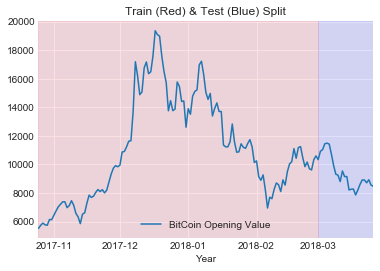

In [24]:
plt.plot(crypto[['open']], '-', label='By Days')
plt.axvspan(crypto.index[0], split_date, color='red', alpha=0.1)
plt.axvspan(split_date, crypto.index[-1], color='blue', alpha=0.1)
plt.xlim(crypto.index[0],crypto.index[-1])
plt.title('Train (Red) & Test (Blue) Split'.format(c_))
plt.legend(['BitCoin Opening Value'])
plt.xlabel('Year');

## Uni-Variate LSTM

In [25]:
#NN need values between 0-1
mm = MinMaxScaler()

#preprocessing
#mm scaler needs atleast a 2D array
train = np.reshape(train.values, (len(train), 1))
train = mm.fit_transform(train)

#here we are predicting Q days ahead
Q = 7
X_train = train[0:len(train)-Q]
y_train = train[Q:len(train)]

#RNN again, needs reshaping
#the shaping choices were picked for if I want to use a multi-dim training
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [26]:
X_train.shape

(120, 1, 1)

In [27]:
y_train.shape

(120, 1)

In [28]:
#X_test.shape

In [29]:
# Making the predictions
test_set = test.values

#reshape for scaling
val = np.reshape(test_set, (len(test_set), 1))
val = mm.transform(val)

In [30]:
y_test = val

In [31]:
#reshaped for NN
X_test = np.reshape(val, (len(val), 1, 1))

In [32]:
Uni_LSTM = 'reset'
# design network
Uni_LSTM = Sequential()
Uni_LSTM.add(LSTM(7, activation='relu', input_shape=(None, 1)))
Uni_LSTM.add(Dropout(0.1))
Uni_LSTM.add(Dense(1))
Uni_LSTM.compile(optimizer='adam', loss='mae')
# fit network
history_uni = Uni_LSTM.fit(X_train, y_train, batch_size=1, epochs=30, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Train on 120 samples, validate on 26 samples
Epoch 1/30
120/120 [==============================] - 5s 38ms/step - loss: 0.3396 - val_loss: 0.1115
Epoch 2/30
120/120 [==============================] - 1s 8ms/step - loss: 0.2246 - val_loss: 0.0557
Epoch 3/30
120/120 [==============================] - 1s 8ms/step - loss: 0.1895 - val_loss: 0.0751
Epoch 4/30
120/120 [==============================] - 1s 11ms/step - loss: 0.1753 - val_loss: 0.0794
Epoch 5/30
120/120 [==============================] - 1s 8ms/step - loss: 0.1686 - val_loss: 0.0826
Epoch 6/30
120/120 [==============================] - 1s 7ms/step - loss: 0.1653 - val_loss: 0.0809
Epoch 7/30
120/120 [==============================] - 1s 9ms/step - loss: 0.1573 - val_loss: 0.0805
Epoch 8/30
120/120 [==============================] - 1s 6ms/step - loss: 0.1666 - val_loss: 0.0731
Epoch 9/30
120/120 [==============================] - 1s 6ms/step - loss: 0.1627 - val_loss: 0.0671
Epoch 10/30
120/120 [==============================] 

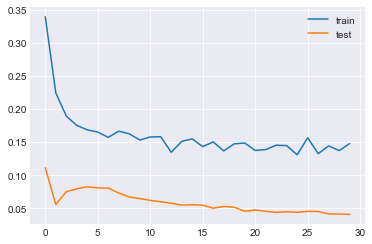

In [33]:
# plot history
plt.plot(history_uni.history['loss'], label='train')
plt.plot(history_uni.history['val_loss'], label='test')
plt.legend()
plt.show()

In [34]:
# Making the predictions
test_set = test.values

#reshape for scaling
val = np.reshape(test_set, (len(test_set), 1))
val = mm.transform(val)

#reshaped for NN
val = np.reshape(val, (len(val), 1, 1))
predicted_BTC_price = Uni_LSTM.predict(val)
predicted_BTC_price = mm.inverse_transform(predicted_BTC_price)[:,0]

In [35]:
pred_uni = pd.DataFrame({'True':test_set,'Pred_Uni':predicted_BTC_price},index=test.index)

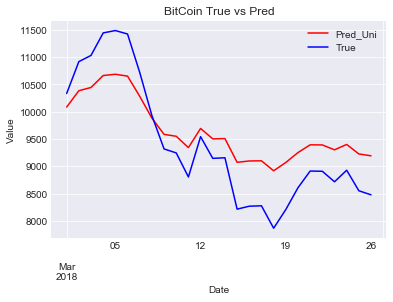

In [36]:
pred_uni.Pred_Uni.plot(c='red')
pred_uni['True'].plot(c='blue')
plt.legend()
plt.title('BitCoin True vs Pred')
plt.ylabel('Value')
plt.xlabel('Date');

- This likely tells us that for the most part the NN assumes the value of bitcoin will remain more stable than it usually does (considering bitcoin's volitile nature)
- This can be remedied by:
    - Increasing the # of feature by which it is calculating the values
    - Adjust the memory that the NN fetchs from in the LSTM cells
    - Train more
        - the fear with that comes from overfitting to pre-existing trends which would ultimately do no more than say 'the score is basically yesterday's score'

## Multi-Variate LSTM RNN

#### Here we aim to use more than simply ```open``` to predict ```open``` *EDIT

### we will use ```['close' , 'volume' , 'cap', 'comments', 'score']```- Today to predict ```close``` -Tomorrow

##### Because ```'Close'``` refers to the end of day_n, and ```['comments', 'score']```, refer to the sums of reddit values at the end of day_n, something needs to be shifted.

In [37]:
#```['comments', 'score']``` need to shifted to be a predictor
#crypto[['comments','score']] = crypto[['comments','score']].shift(-1)

In [38]:
#crypto['close'] = crypto['close'].shift(1)

In [39]:
crypto = crypto.drop(['open','high','low'],axis=1)

Again our data needs to be scaled before being split
    - Otherwise the values at time n would be not properly scaled to the min and max of the data at time n-

In [40]:
crypto = crypto.dropna()

In [41]:
split_date = '2018-03-01'
split_index = int(str(pd.Timestamp(split_date)-crypto.index[0]).split(' ')[0])

cols = crypto.columns.copy(deep=True)

train = crypto[crypto.index<split_date]
test = crypto[crypto.index>=split_date]


print('Training set consists of {}% of data'.format(round(split_index/crypto.shape[0],2)*100))

Training set consists of 83.0% of data


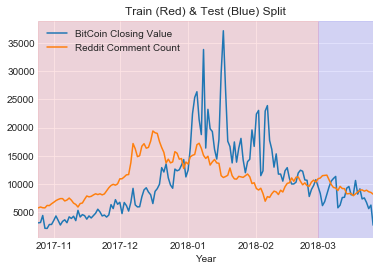

In [42]:
plt.plot(crypto[['comments','close']], '-', label='By Days')
plt.axvspan(crypto.index[0], split_date, color='red', alpha=0.1)
plt.axvspan(split_date, crypto.index[-1], color='blue', alpha=0.1)
plt.xlim(crypto.index[0],crypto.index[-1])
plt.title('Train (Red) & Test (Blue) Split'.format(c_))
plt.legend(['BitCoin Closing Value','Reddit Comment Count'])
plt.xlabel('Year');

In [43]:
scaler = MinMaxScaler()

In [44]:
mm_crypto = scaler.fit_transform(crypto)

In [45]:
mm_crypto = pd.DataFrame(mm_crypto,columns=cols)

In [46]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [47]:
df_shifted = series_to_supervised(mm_crypto.values)
df_shifted.drop(df_shifted.columns[[6,7,8,9]], axis=1, inplace=True)

In [48]:
df_shifted.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.000085,0.119933,0.045033,0.028113,0.023916,0.011398
2,0.011398,0.089590,0.035574,0.030107,0.053844,0.001723
3,0.001723,0.075584,0.027953,0.065484,0.044675,0.000000
4,0.000000,0.005272,0.000000,0.000541,0.021860,0.031722
5,0.031722,0.156081,0.068056,0.000000,0.000000,0.029433


In [49]:
train = df_shifted[:split_index]
test = df_shifted[split_index:]

In [50]:
# split into input and outputs
train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]

In [51]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("Train X shape: {} | Train y : {} | Test X : {} | Test y : {}".format(train_X.shape, train_y.shape, test_X.shape, test_y.shape))

Train X shape: (127, 1, 5) | Train y : (127,) | Test X : (25, 1, 5) | Test y : (25,)


In [52]:
model = 'reset'
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size = 7, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 127 samples, validate on 25 samples
Epoch 1/100
127/127 [==============================] - 3s 27ms/step - loss: 0.3138 - val_loss: 0.1384
Epoch 2/100
127/127 [==============================] - 0s 1ms/step - loss: 0.2200 - val_loss: 0.0638
Epoch 3/100
127/127 [==============================] - 0s 1ms/step - loss: 0.1715 - val_loss: 0.0729
Epoch 4/100
127/127 [==============================] - 0s 2ms/step - loss: 0.1529 - val_loss: 0.0923
Epoch 5/100
127/127 [==============================] - 0s 1ms/step - loss: 0.1462 - val_loss: 0.0934
Epoch 6/100
127/127 [==============================] - 0s 1ms/step - loss: 0.1406 - val_loss: 0.0839
Epoch 7/100
127/127 [==============================] - 0s 1ms/step - loss: 0.1337 - val_loss: 0.0820
Epoch 8/100
127/127 [==============================] - 0s 2ms/step - loss: 0.1276 - val_loss: 0.0771
Epoch 9/100
127/127 [==============================] - 0s 1ms/step - loss: 0.1218 - val_loss: 0.0742
Epoch 10/100
127/127 [=======================

Epoch 81/100
127/127 [==============================] - 0s 1ms/step - loss: 0.0427 - val_loss: 0.0255
Epoch 82/100
127/127 [==============================] - 0s 1ms/step - loss: 0.0430 - val_loss: 0.0331
Epoch 83/100
127/127 [==============================] - 0s 1ms/step - loss: 0.0431 - val_loss: 0.0262
Epoch 84/100
127/127 [==============================] - 0s 1ms/step - loss: 0.0421 - val_loss: 0.0253
Epoch 85/100
127/127 [==============================] - 0s 1ms/step - loss: 0.0432 - val_loss: 0.0296
Epoch 86/100
127/127 [==============================] - 0s 1ms/step - loss: 0.0427 - val_loss: 0.0306
Epoch 87/100
127/127 [==============================] - 0s 1ms/step - loss: 0.0422 - val_loss: 0.0249
Epoch 88/100
127/127 [==============================] - 0s 1ms/step - loss: 0.0425 - val_loss: 0.0280
Epoch 89/100
127/127 [==============================] - 0s 1ms/step - loss: 0.0421 - val_loss: 0.0295
Epoch 90/100
127/127 [==============================] - 0s 1ms/step - loss: 0.0421

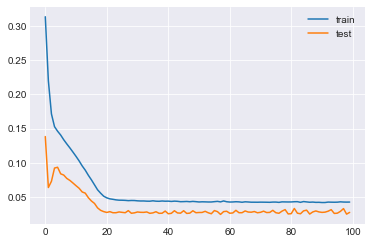

In [53]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [54]:
# invert scaling for forecast
yhat = model.predict(test_X)
inv_yhat = pd.concat((pd.Series(yhat[:,0],name='Pred'), pd.DataFrame(test_X[:, 0,1:])), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
pred_multi = pd.DataFrame(inv_yhat).drop([1,2,3,4],axis=1)
pred_multi.columns = ['Pred_Multi']

In [55]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = pd.concat((pd.Series(test_y[:,0],name='True'), pd.DataFrame(test_X[:, 0,1: ])), axis=1)
inv_y = scaler.inverse_transform(inv_y)

pred_ = pd.DataFrame(inv_y).drop([1,2,3,4],axis=1)
pred_.columns = ['True']

/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


In [56]:
pred_multi = pred_multi.merge(pred_,left_index=True,right_index=True,how='left')

In [57]:
pred_multi.head()

,Pred_Multi,True
0,10953.672100,11034.102647
1,11034.017864,11459.076216
2,11411.079419,11503.560256
3,11413.691161,11554.415200
4,11495.144382,10700.212125


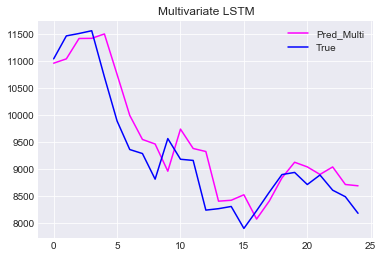

In [58]:
plt.title('Multivariate LSTM')
pred_multi.Pred_Multi.plot(c='magenta')
pred_multi['True'].plot(c='blue')
plt.legend();

In [59]:
pred_uni = pred_uni.shift(1).dropna()
pred_multi.index = pred_uni.index
all_pred = pred_uni.merge(pred_multi,left_index=True,right_index=True)

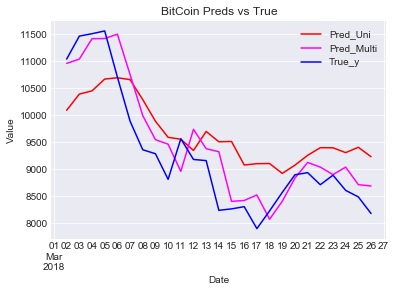

In [60]:
all_pred.Pred_Uni.plot(c='red')
all_pred.Pred_Multi.plot(c='magenta')
all_pred.True_y.plot(c='blue')
plt.title('BitCoin Preds vs True')
plt.legend()
plt.ylabel('Value')
plt.xlabel('Date');